### Problem Statement
We have been hearing about the issue of different types of Full-Self Driving(FSD) technology in mobility domain and the one which has been in news has been predominantly Tesla. The primary objective for a vehicle while driving is to detect varied obstacles and efficiently cross them while following the rules of the road. The signals on the road helps in commuting from one place to another. The dataset we have here are a collation these signals on the road in images. We would use these images to identify the signals.

### Data
Data has been segregated into two separate folders. "images" folder has the collection of all these signal images on the road. "annotations" folder has an xml file corresponding to each "image" file. The xml file gives the details of the signals present on the image. It helps to locate the signals on the images. The signals are identified as one of the following four
1. Speed Limit
2. Cross Walk
3. Traffic Light
4. Stop Sign

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

To start with initialise the path of Images and Annotations and create a data frame of image data provided in xml kept in Annotations folder.

In [2]:
# Image paths
img_base_out = os.getcwd()
print("Current Working directory:",img_base_out)
img_crop_path_out = img_base_out + '/crop/'
print("Output Cropped Image directory:",img_crop_path_out)
img_base_in = '/kaggle/input/road-sign-detection/'
print("Input base directory:",img_base_in)
img_path_in = img_base_in + 'images/'
print("Input Image directory:",img_path_in)
img_ann_path_in = img_base_in + 'annotations/'
print("Input Annotations directory:",img_ann_path_in)

# Data Frame column header
df_cols = ['ImgID', 'Width', 'Height', 'Type', 'xMin', 'yMin', 'xMax', 'yMax']

# Initialise data frame for all files
df_files = pd.DataFrame(columns=df_cols)


Current Working directory: /kaggle/working
Output Cropped Image directory: /kaggle/working/crop/
Input base directory: /kaggle/input/road-sign-detection/
Input Image directory: /kaggle/input/road-sign-detection/images/
Input Annotations directory: /kaggle/input/road-sign-detection/annotations/


Get all the images and annotations in the directory
Images are all in png format while annotations are xml format. xml files contain required metadata to read through the image

In [3]:
# Initialise list of files
list_of_files = []

# Loop each xml file from annotation
for dirname, _, filenames in os.walk(img_ann_path_in):
    for file in filenames:
        if (file.endswith(".xml")):
            list_of_files.append(file)
            
list_of_files[:5]

['road732.xml', 'road518.xml', 'road717.xml', 'road362.xml', 'road492.xml']

The annotation files give details of different signals available in the images. It also provides us with the boundary of these signals. 
With this, we can extract multiple images of different signals from the data of boundary provided in the annotation file for each image. To create a predictive model, we would need to convert images into tabular data to assess and predict upon. Further sections of code would talk about analysis of data and the actions being taken via the code.

In [4]:
# Initialise the main image data array
# Create 785 rows which will be used for row # 0
img_data = [(0) for _ in range(785)]

#### Data Analysis
* Images are all in png format
* Each image is of different size
* They may contain multiple signals of different sizes
* Each image has a corressponding xml file which describes the different types of signal and their position in the image

#### Further Actions
* Extract the required data from xml file available for each image
* Loop through each xml file and use the boundaries provided to crop the image and get just the signal image
* Convert the image to a black and white image
* Resize the images processed to 28 by 28 pixel dimension. This would create uniformity in the images and will help us in further conversion to an array
* Save the processed images and segregate them based on signal type into different folders
* Flatten the image data into array data so that we can use it for further prediction.

In [5]:
import xml.etree.cElementTree as et
from PIL import Image

# Create directory for saving cropped images
if not os.path.exists(img_crop_path_out):
    os.mkdir(img_crop_path_out, mode=0o777)

# Loop through each image to get all signals present in it
for file in list_of_files:
    img_ann_file = img_ann_path_in + file
    # Read xml file
    img_root = et.parse(img_ann_file)
    filename = img_root.find('./filename').text
    objects = img_root.findall('./object')
    img_width = img_root.find('./size/width').text
    img_height = img_root.find('./size/height').text

    # Create xml nested table
    img_xml_data = [[filename, img_width, img_height, obj.find('./name').text, obj.find('bndbox/xmin').text, obj.find(
        'bndbox/ymin').text, obj.find('bndbox/xmax').text, obj.find('bndbox/ymax').text] for obj in objects]

    # Create data frame out of the xml extracted data
    df_xml = pd.DataFrame(img_xml_data, columns=df_cols)

    # Append the new file into the main data frame
    df_files = pd.concat([df_files,df_xml], axis=0)

    # Open each image and read as balck and white
    img = Image.open(img_path_in + filename).convert('L')

    # Set image count incase each image has multiple signals
    img_count = 0

    # Loop through objects to get the boundary of signals in the image
    for obj in objects:
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        img_type = obj.find('./name').text
        img_count += 1

        # Crop image and resize them to dimesions of 28 by 28 pixels
        img_crop = img.crop((xmin, ymin, xmax, ymax)).resize((28,28))

        # Make sub-directory for each signal type
        if not os.path.exists(img_crop_path_out + img_type):
            os.mkdir(img_crop_path_out + img_type, mode=0o777)

        # Save the cropped image in the specified signal type folder
        crop_filepath = img_crop_path_out + img_type + '/' + str(img_count) + "_" + filename
        img_crop.save(crop_filepath)
        
        # Convert images into data
        # a 28 by 28 array would be created
        data = np.array(img_crop)
        img_cnv = Image.fromarray(data.astype('uint8'))
        img_cnv.save(crop_filepath)
        
        # Move the 28 rows into single row, which would create 784 columns
        data_flatten = data.reshape((1,784))
        
        # Each row would signify an image which was cropped and converted
        # Including a new column which indicates image file name
        flnm_array = np.array([str(img_count) + "_" + filename.rstrip('.png')])
        
        # Add image name column to the array
        data_flt = np.concatenate((flnm_array,data_flatten), axis = None)
        
        # Include the new image data into array of previously saved images
        img_data = np.vstack((img_data,data_flt))

#### Data Check
View one of the cropped, resized and, discoloured images

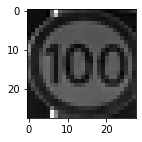

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,2))
image = img_cnv
plt.imshow(np.array(image).reshape(28,28), cmap=plt.cm.gray)

#### Data Check
View the image array data created 

In [7]:
img_data

array([['0', '0', '0', ..., '0', '0', '0'],
       ['1_road732', '181', '185', ..., '107', '119', '110'],
       ['2_road732', '100', '115', ..., '84', '103', '93'],
       ...,
       ['1_road620', '105', '98', ..., '90', '88', '86'],
       ['1_road701', '68', '67', ..., '63', '63', '63'],
       ['2_road701', '68', '68', ..., '72', '72', '74']], dtype='<U21')

#### Data Analysis
* Initially, we are trying to identify the speed limits provided on the images. 
* This would mean, no action being taken on images associated to types CrossWalk, Traffic Light and, Stop Signals.
* It would be easy for us to segregate the image type as the earlier cropped, resized and discoloured images which were stored in separate folders.

#### Further Action
* Get list of images which are classified as speed limit images.
* Move images array data into a data frame.
* Filter image data frame to extract just the speed limit signal data
* Impute a new column with the speed limit numbers found on the image. This column would be used as the Response Variable for our prediction.
* Determine why Logistic regression model is suitable for the data.
* We will predict the characters of the images by defining the speed limit numbers.

In [8]:
# Initialise list of files
list_of_files = []

# SpeedLimit files are stored in folder by name of same signal type
# We know the output directory
# Loop each directory to find the speed limit files and log the filenames into a list
for _, subdirs, _ in os.walk(img_crop_path_out):
    for subdir in subdirs:
        if (subdir.upper().startswith("SPEED")):
            for _,_,filenames in os.walk(img_crop_path_out + subdir):
                for file in filenames:
                    if (file.endswith(".png")):
                        list_of_files.append(file.rstrip('.png'))
            
# Create column headers
pixel_columns = [('pixel' + str(count)) for count in range(784)]
pixel_columns.insert(0, 'filename')

# Create Dataframe out of image data
df_img = pd.DataFrame(img_data, columns = pixel_columns)

# Filter Dataframe such that it only has images for speed limit
df_img_speed = df_img[df_img['filename'].map(lambda x: x).isin(list_of_files)]

df_img_speed[:5]

,filename,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,1_road732,181,185,182,184,185,183,182,192,169,...,193,181,133,86,114,138,108,107,119,110
2,2_road732,100,115,123,94,108,105,80,73,102,...,215,122,87,84,89,100,89,84,103,93
3,1_road518,164,161,157,158,159,172,117,53,67,...,127,148,173,181,158,146,150,152,153,153
4,1_road717,81,80,77,71,68,67,68,71,83,...,89,82,78,78,83,84,83,81,82,83
5,2_road717,71,73,75,75,72,71,72,72,65,...,92,90,95,107,105,93,78,72,73,77


#### Data Analysis
* Now that we have data frame with just the speed limits, we find ourselves with data with numbers in the images
* Our plan is to predict the number on the images 
* This would mean our dataframe should have a column indicating the limit number

#### Further Action
* Impute a new column with the speed limit numbers found on the image. This column would be used as the Response Variable for our prediction.

In [9]:
# Load csv file which has speed values indicated on the signal
data_speed = pd.read_csv('/kaggle/input/road-sign-detection-speed-limit/speedlimit.csv',header = None, names = ['Id','speed'])

# Join the dataframes to process further
speedlimit_data = pd.merge(df_img_speed, data_speed, left_on='filename', right_on='Id', how='left').drop('Id', axis=1)
speedlimit_data

,filename,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,speed
0,1_road732,181,185,182,184,185,183,182,192,169,...,181,133,86,114,138,108,107,119,110,120
1,2_road732,100,115,123,94,108,105,80,73,102,...,122,87,84,89,100,89,84,103,93,100
2,1_road518,164,161,157,158,159,172,117,53,67,...,148,173,181,158,146,150,152,153,153,80
3,1_road717,81,80,77,71,68,67,68,71,83,...,82,78,78,83,84,83,81,82,83,100
4,2_road717,71,73,75,75,72,71,72,72,65,...,90,95,107,105,93,78,72,73,77,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,2_road227,92,88,80,71,68,69,77,96,118,...,77,81,82,78,72,70,69,70,70,100
779,1_road660,80,85,86,88,85,89,87,88,124,...,215,167,101,72,80,87,87,67,74,40
780,1_road620,105,98,98,99,94,95,93,88,86,...,97,102,99,95,88,89,90,88,86,50
781,1_road701,68,67,63,65,68,67,66,59,141,...,94,88,72,62,63,63,63,63,63,120


### Prediction Model
Our data is basically a set of images with varying types of signals which are found on the roadways. The objective is to identify/classify these signals into different types. One such type is the speed limit, this can be sub-classified based on speeds indicated on the image. The speed limit values are not continuous and can be considered as a classification For Example, 5, 20, 40, 80 or 100. 
Logistic regression is a model for classification and the data for speed limit fits the profile for the classification of speeds depicted on these images.

#### Further Action
* Set target variable
* Split the images into Test and Train data at a 40 to 60 split respectively.
* Predict the characters of the images by defining the speed limit numbers.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Get Explanatory variables
x = speedlimit_data[speedlimit_data.columns[1:785]]

# Get the Response variable
y = speedlimit_data[['speed']]

# Split the data
Ex_train,Ex_test,Res_train,Res_test = train_test_split(x,y,train_size=.6,random_state=0)
